# CTD Transect Plotting

This notebook demonstrates a simple plotting exercise for CTD data across a transect, using the output of a VirtualShip expedition. There are example plots embedded at the end, but these will ultimately be replaced by your own versions as you work through the notebook.

We can plot physical (temperature, salinity) or biogeochemical data (oxygen, chlorophyll, primary production, phyto/zoo-plankton, nutrients, pH) as measured by the VirtualShip `CTD` and `CTD_BGC` instruments, respectively.

The plot(s) we will produce are simple plots which follow the trajectory of the expedition as a function of distance from the first waypoint, and are intended to be a starting point for your analysis. 

<div class="alert alert-block alert-info"> 
<b>Note:</b> This notebook assumes that each waypoint in the expedition is further from the start than the last waypoint. The code will still work if not, but the resultant plots might not be very intuitive.
</div>

## Set up

#### Imports

The first step is to import the Python packages required for post-processing the data and plotting. 

<div class="alert alert-block alert-success"> 
<b>Tip:</b> You may need to set the Kernel to the relevant (Conda) environment in the top right of this notebook to access the required packages! 
</div>

In [44]:
import cmocean.cm as cmo
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt


#### Data directory

Next, you should set `data_dir` to be the path to your expedition results in the code block below. You should replace `"/path/to/EXPEDITION/results/"` with the path for your machine.

<div class="alert alert-block alert-success"> 
<b>Tip:</b> You can get the path to your expedition results by navigating to the `results` folder in Terminal (using `cd`) and then using the `pwd` command. This will print your working directory which you can copy to the `data_dir` variable in this notebook. Don't forget to keep it as a string (in "quotation" marks)!
</div>



In [ ]:
data_dir = "/path/to/EXPEDITION/results/"  # set this to be where your expedition output data is located on your (virtual) machine

#### Variable choice

You should now consider which variable from your CTD casts you would like to plot. Which ones are available to you will depend on whether you have used the `CTD` (physical variables) or `CTD_BGC` (biogeochemical) instrument, or both. Below is a list of all valid variable choices for both instruments...

`CTD` (physical):
- "temperature"
- "salinity"

`CTD_BGC` (biogeochemical):
- "oxygen"
- "nitrate"
- "phosphate"
- "ph"
- "zooplankton"
- "phytoplankton"
- "primary_production"
- "chlorophyll"

Copy one of the above to `plot_variable` below:

In [74]:
plot_variable = "temperature"  # change this to your chosen variable


We also define the `VARIABLES` dictionary here, which we use to store some parameters for the plots related to each variable choice (e.g. labels, what units each is in, and which colour map we should use for the plots).

<div class="alert alert-block alert-success"> 
<b>Tip:</b> You don't need to change anything here, but should you wish to change the colour scheme (`cmap`) for any CTD variable you can do so. At the moment it's set to use relevant cmaps from the cmocean Python package, which has developed specialist colour schemes for oceanographic data applications.
</div>

In [75]:
VARIABLES = {
    "temperature": {
        "cmap": cmo.thermal,
        "label": "Temperature (°C)",
        "ds_name": "temperature",
    },
    "salinity": {
        "cmap": cmo.haline,
        "label": "Salinity (psu)",
        "ds_name": "salinity",
    },
    "oxygen": {
        "cmap": cmo.oxy,
        "label": r"Dissolved oxygen (mmol m$^{-3}$)",
        "ds_name": "o2",
    },
    "nitrate": {
        "cmap": cmo.matter,
        "label": r"Nitrate (mmol m$^{-3}$)",
        "ds_name": "no3",
    },
    "phosphate": {
        "cmap": cmo.matter,
        "label": r"Phosphate (mmol m$^{-3}$)",
        "ds_name": "po4",
    },
    "ph": {
        "cmap": cmo.balance,
        "label": "pH",
        "ds_name": "ph",
    },
    "zooplankton": {
        "cmap": cmo.algae,
        "label": r"Total zooplankton (mmol m$^{-3}$)",
        "ds_name": "zooc",
    },
    "phytoplankton": {
        "cmap": cmo.algae,
        "label": r"Total phytoplankton (mmol m$^{-3}$)",
        "ds_name": "phyc",
    },
    "primary_production": {
        "cmap": cmo.matter,
        "label": r"Total primary production of phytoplankton (mg m$^{-3}$ day$^{-1}$)",
        "ds_name": "nppv",
    },
    "chlorophyll": {
        "cmap": cmo.algae,
        "label": r"Chlorophyll (mg m$^{-3}$)",
        "ds_name": "chl",
    },
}

## Load data

We are now ready to read in the data. You can carry on executing the next cells without making changes to the code...

In [76]:
# load CTD data
filename = (
    "ctd.zarr" if plot_variable in ["temperature", "salinity"] else "ctd_bgc.zarr"
)
ctd_ds = xr.open_dataset(f"{data_dir}/{filename}")
if ctd_ds["trajectory"].size <= 1:
    raise ValueError("Number of waypoints must be > 1")

## Data post-processing

Before we can continue, we need to do some post-processing to get it ready for plotting. Below are various helper functions which perform tasks such as calculating the distance of each waypoint from the start, capturing only the downcasts of the CTD casts, as well as some other utility methods. 

In [77]:
# utility functions


def haversine(lon1, lat1, lon2, lat2):
    """Great-circle distance (meters) between two points."""
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon, dlat = lon2 - lon1, lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 6371000 * c


def distance_from_start(ds):
    """Add 'distance' variable: meters from first waypoint."""
    lon0, lat0 = (
        ds.isel(trajectory=0)["lon"].values[0],
        ds.isel(trajectory=0)["lat"].values[0],
    )
    d = np.zeros_like(ds["lon"].values, dtype=float)
    for ob, (lon, lat) in enumerate(zip(ds["lon"], ds["lat"], strict=False)):
        d[ob] = haversine(lon, lat, lon0, lat0)
    ds["distance"] = xr.DataArray(
        d,
        dims=ds["lon"].dims,
        attrs={"long_name": "distance from first waypoint", "units": "m"},
    )
    return ds


def descent_only(ds, variable):
    """Extract descending CTD data (downcast), pad with NaNs for alignment."""
    min_z_idx = ds["z"].argmin("obs")
    da_clean = []
    for i, traj in enumerate(ds["trajectory"].values):
        idx = min_z_idx.sel(trajectory=traj).item()
        descent_vals = ds[variable][
            i, : idx + 1
        ]  # take values from surface to min_z_idx (inclusive)
        da_clean.append(descent_vals)
    max_len = max(len(arr[~np.isnan(arr)]) for arr in da_clean)
    da_padded = np.full((ds["trajectory"].size, max_len), np.nan)
    for i, arr in enumerate(da_clean):
        da_dropna = arr[~np.isnan(arr)]
        da_padded[i, : len(da_dropna)] = da_dropna
    return xr.DataArray(
        da_padded,
        dims=["trajectory", "obs"],
        coords={"trajectory": ds["trajectory"], "obs": np.arange(max_len)},
    )


def build_masked_array(data_up, profile_indices, n_profiles):
    arr = np.full((n_profiles, data_up.shape[1]), np.nan)
    for i, idx in enumerate(profile_indices):
        if idx is not None:
            arr[i, :] = data_up.values[idx, :]
    return arr


def get_profile_indices(distance_1d):
    """
    Returns regular distance bins and profile indices for CTD transect plotting.

    Bin size is set to one order of magnitude lower than max distance.
    """
    dist_min, dist_max = float(distance_1d.min()), float(distance_1d.max())
    if dist_max > 1e6:
        dist_step = 1e5
    elif dist_max > 1e5:
        dist_step = 1e4
    elif dist_max > 1e4:
        dist_step = 1e3
    else:
        dist_step = 1e2  # fallback for very short transects

    distance_regular = np.arange(dist_min, dist_max + dist_step, dist_step)
    threshold = dist_step / 2
    profile_indices = [
        np.argmin(np.abs(distance_1d.values - d))
        if np.min(np.abs(distance_1d.values - d)) < threshold
        else None
        for d in distance_regular
    ]
    return profile_indices, distance_regular


Now we will execute the utility functions, plus define some extra useful arrays to be used for the plotting...

In [78]:
# add distance from start
ctd_distance = distance_from_start(ctd_ds)

# exract descent-only data
z_up = descent_only(ctd_distance, "z")
d_up = descent_only(ctd_distance, "distance")
var_up = descent_only(ctd_distance, VARIABLES[plot_variable]["ds_name"])

# 1d array of depth dimension (from deepest trajectory)
traj_idx, obs_idx = np.where(z_up == np.nanmin(z_up))
z1d = z_up.values[traj_idx[0], :]

# distance as 1d array
distance_1d = d_up.isel(obs=0)

## Plotting

<div class="alert alert-block alert-info"> 
<b>Note:</b> The plots produced next are a starting point for your analysis. You are encouraged to make adjustments, for example axis limits and scaling if the defaults not best suited to your specific data. Use your preferred AI coding assistant for help!
</div>

We are now ready to plot our transect data. We will use distance from the first waypoint/CTD cast for the x-axis, and water column depth for the y-axis. The data for the chosen variable will then be plotted according to the colour map. The CTD casts are likely to be different depths because some parts of the ocean are of course shallower than others.

There are a few extra steps below which arrange the CTD casts into regular distance bins, so as to clearly demonstrate where along the transect we made CTD casts and indeed where there are gaps.


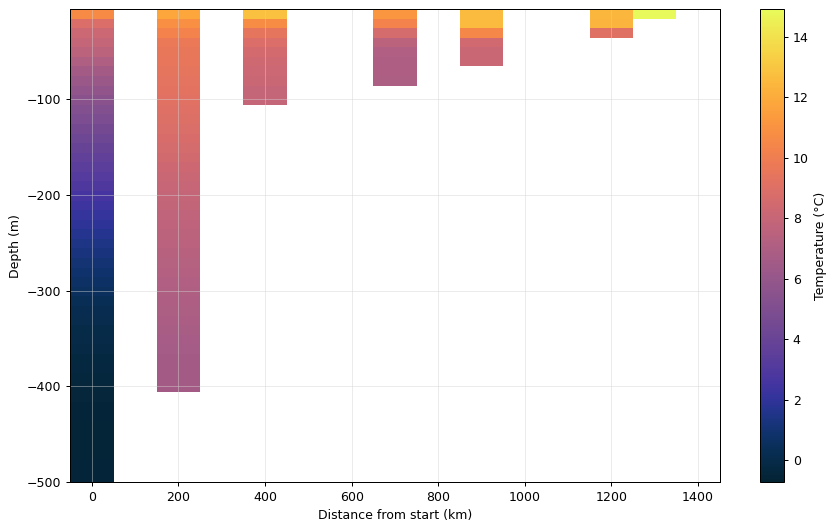

In [ ]:
# regularised transect
profile_indices, distance_regular = get_profile_indices(distance_1d)
var_masked = build_masked_array(var_up, profile_indices, len(distance_regular))

xticks_reg = np.linspace(
    float(distance_regular.min()),
    float(distance_regular.max()),
    len(distance_regular),
)

# plot regularised transect
fig, ax = plt.subplots(figsize=(10, 6), dpi=90)

ax.grid(True, which="both", color="lightgrey", linestyle="-", linewidth=0.7, alpha=0.5)

mesh = ax.pcolormesh(
    distance_regular / 1000,  # distance in km
    z1d,
    var_masked.T,
    cmap=VARIABLES[plot_variable]["cmap"],
)

ax.set_ylabel("Depth (m)")
ax.set_xlabel("Distance from start (km)")

plt.colorbar(mesh, ax=ax, label=VARIABLES[plot_variable]["label"])
plt.tight_layout()

In the plot above, we can see that there are gaps in the transects where no CTD casts have been made. After all, it's impossible to take measurements at every point across the transect! There will always be gaps making 10s of deployments across transects 1000s of kms long 🙃 This makes expedition/sampling site planning all the more important...

We can also also plot a 'filled' version without the distance bins, to give an alternative view of the evolution across the transect which is not dominated by gaps and white space. This time we will also add a 'sea bed' to the plot.

<div class="alert alert-block alert-info"> 
<b>Note:</b> It is important to remember that the gaps do actually exist in reality and this is a caveat which must be considered when interpreting the transect derived from CTD casts. Indeed, if you look at the x-axis of the plot below you will see that the deployments are not necessarily regularly spaced and some gaps are larger than others.
</div>

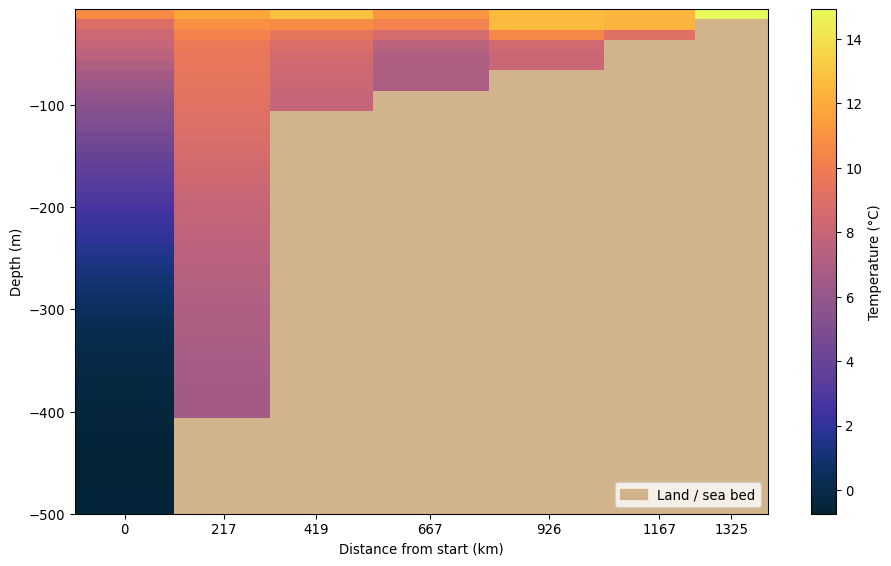

In [ ]:
# plot 'filled' transect (with sea bed visualised as well)
fig, ax = plt.subplots(figsize=(10, 6), dpi=96)

mesh = ax.pcolormesh(
    distance_1d / 1000,  # distance in km
    z1d,
    var_up.T,
    cmap=VARIABLES[plot_variable]["cmap"],
)

seabed = xr.where(np.isnan(var_up), 1, np.nan)  # sea bed
ax.pcolormesh(
    distance_1d / 1000,  # distance in km
    z1d,
    seabed.T,
    cmap=mcolors.ListedColormap([mcolors.to_rgba("tan"), mcolors.to_rgba("white")]),
)

tan_patch = mpatches.Patch(color=mcolors.to_rgba("tan"), label="Land / sea bed")
ax.legend(handles=[tan_patch], loc="lower right")

ax.set_xticks(distance_1d / 1000)

ax.set_ylabel("Depth (m)")
ax.set_xlabel("Distance from start (km)")

plt.colorbar(mesh, ax=ax, label=VARIABLES[plot_variable]["label"])
plt.tight_layout()